In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import plotly.express as px
from pyspark.sql import SparkSession

In [2]:
HOME_PATH = os.path.dirname(os.getcwd())

In [4]:
spark = SparkSession.builder.appName("EDA").getOrCreate()
df = spark.read.parquet(f"{HOME_PATH}/data/2019-Oct.parquet", header=True, inferSchema=True)


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/09/04 14:18:20 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# EDA

## Univariate Analysis

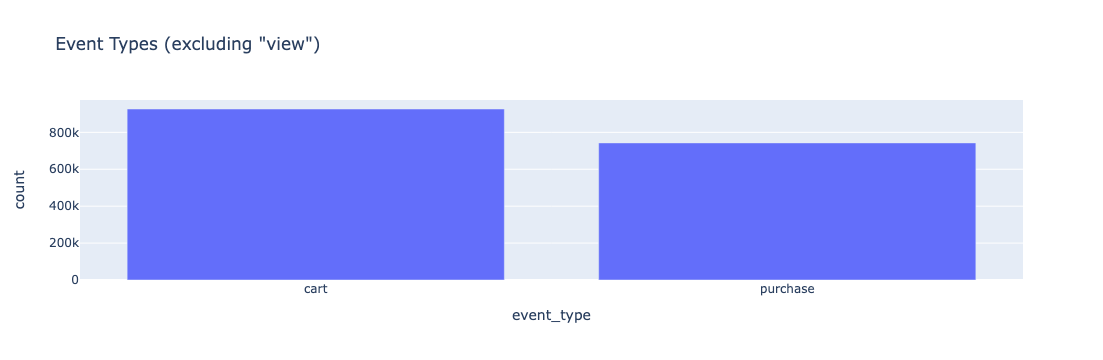

In [4]:
event_type_counts = df.groupby("event_type").count().orderBy("count", ascending=False)

# Convert Spark DataFrame to Pandas DataFrame, excluding "view" event type
df_event_types = event_type_counts.filter(event_type_counts.event_type != "view").toPandas()

# Create the bar plot using Plotly Express
fig = px.bar(df_event_types, x='event_type', y='count', 
             title='Event Types (excluding "view")')

# Show the plot
fig.show()

In [5]:
# Top 10 brand
top_10_brands = df.groupBy("brand").count().orderBy("count", ascending=False).limit(10)


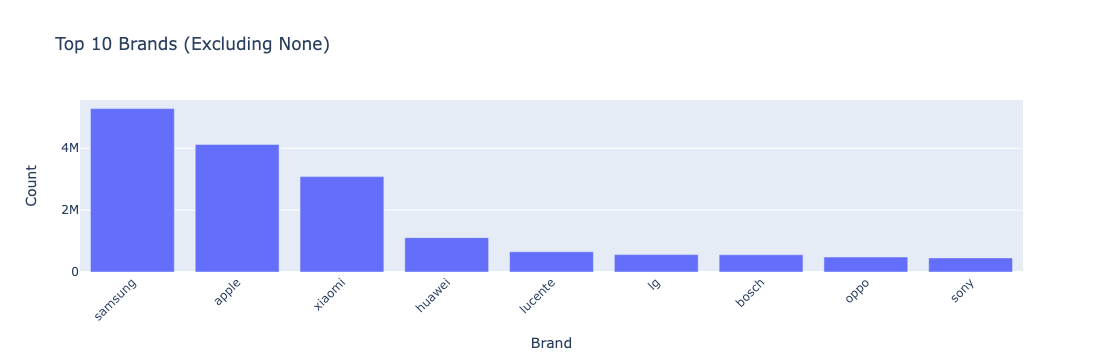

In [6]:
# Convert Spark DataFrame to Pandas DataFrame
df_top_brands = top_10_brands.toPandas()

# Filter out None values
df_top_brands = df_top_brands[df_top_brands['brand'].notnull()]

fig = px.bar(df_top_brands, x='brand', y='count', 
             title='Top 10 Brands (Excluding None)',
             labels={'brand': 'Brand', 'count': 'Count'},
             )

fig.update_layout(xaxis_tickangle=-45)
fig.show()

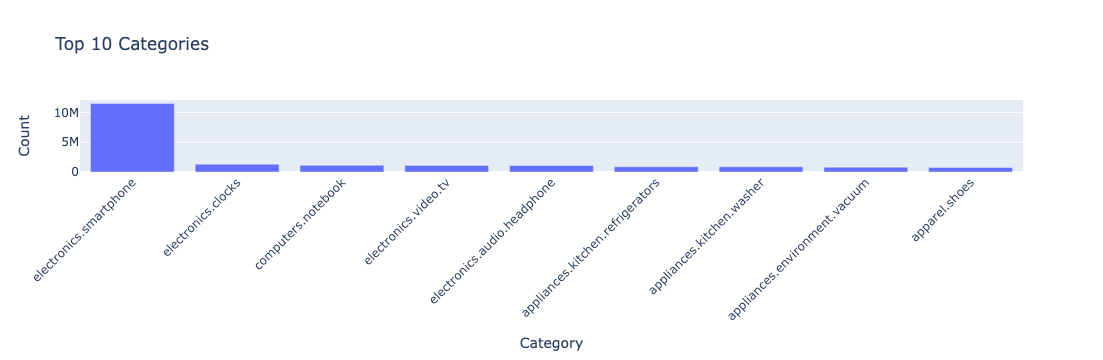

In [7]:
top_10_category = df.groupBy("category_code").count().orderBy("count", ascending=False).limit(10)

df_top_categories = top_10_category.toPandas()
df_top_categories = df_top_categories[df_top_categories['category_code'].notnull()]

fig = px.bar(df_top_categories, x='category_code', y='count', 
             title='Top 10 Categories',
             labels={'category_code': 'Category', 'count': 'Count'},
            )

fig.update_layout(xaxis_tickangle=-45)
fig.show()


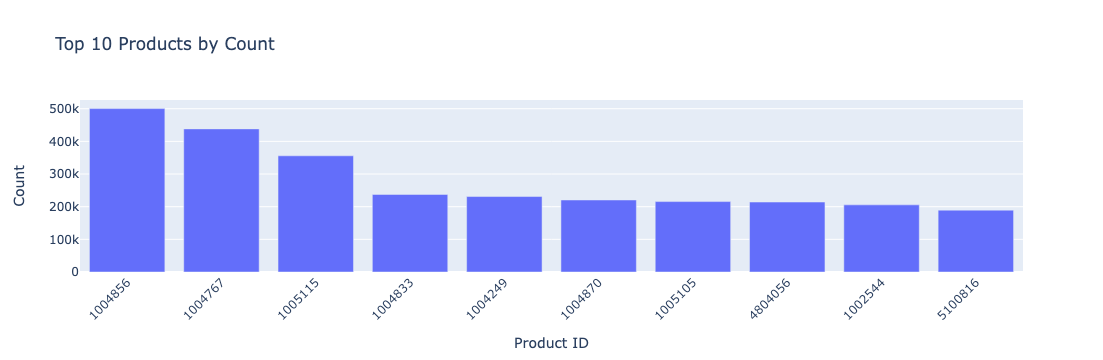

In [8]:
# Top 10 products by count
top_10_products = df.groupBy("product_id") \
    .count() \
    .orderBy("count", ascending=False) \
    .limit(10)

# Convert to pandas DataFrame for plotting
pd_top_10_products = top_10_products.toPandas()

# Convert product_id to string
pd_top_10_products['product_id'] = pd_top_10_products['product_id'].astype(str)

# Create the plot using plotly express
fig = px.bar(pd_top_10_products, 
             x='product_id', 
             y='count',
             title='Top 10 Products by Count',
             labels={'product_id': 'Product ID', 'count': 'Count'},
             color_continuous_scale='viridis')

fig.update_layout(xaxis_tickangle=-45)
fig.show()

## Multivariate Analysis

### show time line of event_type


In [9]:
from pyspark.sql.functions import hour


df = df.withColumn("hour", hour("event_time"))



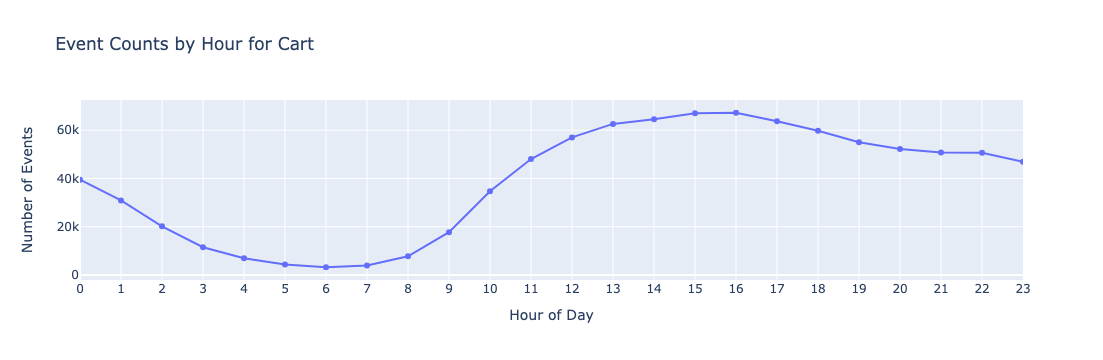

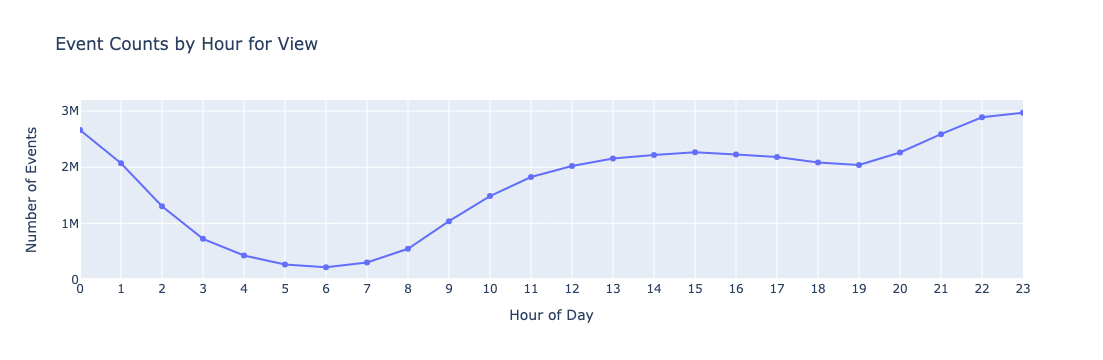

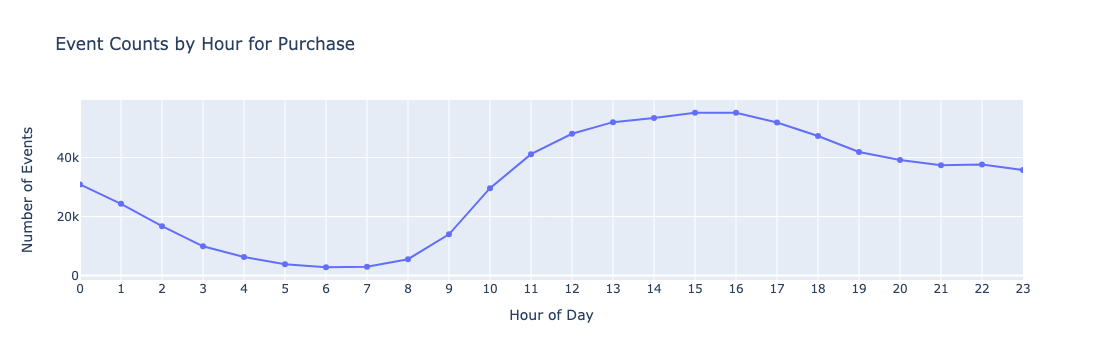

24/09/04 13:55:25 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


In [10]:
# Assuming df is a Spark DataFrame, convert it to Pandas DataFrame
df_pandas = df.groupBy('event_type', 'hour').count().toPandas()



# Create separate charts for each event type
event_types = df_pandas['event_type'].unique()

for event_type in event_types:
    df_event = df_pandas[df_pandas['event_type'] == event_type].sort_values(by='hour')
    
    fig = px.line(df_event, x='hour', y='count',
                  title=f'Event Counts by Hour for {event_type.capitalize()}',
                  labels={'hour': 'Hour of Day', 'count': 'Number of Events'},
                  markers=True)

    fig.update_layout(
        xaxis_title='Hour of Day',
        yaxis_title='Number of Events',
        xaxis=dict(
            tickmode='linear',
            tick0=0,
            dtick=1,
            range=[0, 23]
        ),
        hovermode='x unified'
    )

    # Show the plot
    fig.show()

# market basket analysis

In [5]:
# Find products purchased together in the same session
session_purchases = df.filter(df.event_type == "purchase")
from pyspark.sql.functions import collect_set
product_combinations = session_purchases.groupBy("user_session").agg(collect_set("product_id").alias("product_id"))


In [7]:
# Get the top 3 most common product combinations
from itertools import combinations
from pyspark.sql.functions import udf, explode, desc
from pyspark.sql.types import ArrayType, StringType

@udf(returnType=ArrayType(ArrayType(StringType())))
def get_product_combinations(product_list):
    return [sorted(list(combo)) for combo in combinations(product_list, 3)]

product_combinations = product_combinations.withColumn("product_combos", get_product_combinations("product_id"))
all_combos = product_combinations.select(explode("product_combos").alias("combo"))

top_10_combos = all_combos.groupBy("combo").count().orderBy(desc("count")).limit(10)

print("\nTop 10 of 3 product combinations purchased together in the same session:")
top_10_combos.show(truncate=False)


Top 3 product combinations purchased together in the same session:


+---------------------------+-----+
|combo                      |count|
+---------------------------+-----+
|[1004767, 1004833, 1004856]|65   |
|[1004833, 1004836, 1004856]|44   |
|[1004767, 1004833, 1004836]|35   |
|[1004750, 1004767, 1004856]|25   |
|[1004767, 1004836, 1004856]|24   |
|[1004750, 1004767, 1004836]|23   |
|[1004833, 1004856, 1004870]|23   |
|[1004750, 1004833, 1004856]|22   |
|[1004767, 1004856, 1004870]|22   |
|[1004750, 1004767, 1004833]|22   |
+---------------------------+-----+



In [24]:
from pyspark.sql.functions import array_contains, col
# Replace 'given_product_id' with the actual product ID you are interested in.
given_product_id = '1004227'

# Filter the combinations to include only those that contain the given product
filtered_combos = all_combos.filter(array_contains(col("combo"), given_product_id))

# Group by the combination and count how many times each combo occurs
top_combos_for_given_product = filtered_combos.groupBy("combo").count().orderBy(desc("count"))

print(f"\nTop product combinations purchased together with product '{given_product_id}':")
top_combos_for_given_product.show(truncate=False)


Top product combinations purchased together with product '1004227':


+---------------------------+-----+
|combo                      |count|
+---------------------------+-----+
|[1004227, 1004767, 1801555]|10   |
|[1004227, 1801555, 4201541]|8    |
|[1004227, 1004767, 1004833]|7    |
|[1004227, 1004833, 1004856]|6    |
|[1004227, 1004767, 1004856]|6    |
|[1004227, 1004833, 1801555]|5    |
|[1004227, 1004767, 4201541]|4    |
|[1003316, 1004226, 1004227]|4    |
|[1004227, 1004856, 1801555]|4    |
|[1004227, 1004237, 1005115]|4    |
|[1004225, 1004226, 1004227]|3    |
|[1002544, 1004227, 1004767]|3    |
|[1003316, 1003317, 1004227]|3    |
|[1002544, 1003306, 1004227]|3    |
|[1004227, 1801555, 4201530]|3    |
|[1004227, 1004767, 4201530]|3    |
|[1004226, 1004227, 1005115]|3    |
|[1004209, 1004227, 1004767]|3    |
|[1003316, 1004227, 1005115]|3    |
|[1004227, 1004767, 1004870]|3    |
+---------------------------+-----+
only showing top 20 rows

